# Practice Lab: Advice for Applying Machine Learning
In this lab, you will explore techniques to evaluate and improve your machine learning models.

# Outline
- [ 1 - Packages ](#1)
- [ 2 - Evaluating a Learning Algorithm (Polynomial Regression)](#2)
  - [ 2.1 Splitting your data set](#2.1)
  - [ 2.2 Error calculation for model evaluation, linear regression](#2.2)
    - [ Exercise 1](#ex01)
  - [ 2.3 Compare performance on training and test data](#2.3)
- [ 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> ](#3)
  - [ 3.1 Plot Train, Cross-Validation, Test](#3.1)
  - [ 3.2 Finding the optimal degree](#3.2)
  - [ 3.3 Tuning Regularization.](#3.3)
  - [ 3.4 Getting more data: Increasing Training Set Size (m)](#3.4)
- [ 4 - Evaluating a Learning Algorithm (Neural Network)](#4)
  - [ 4.1 Data Set](#4.1)
  - [ 4.2 Evaluating categorical model by calculating classification error](#4.2)
    - [ Exercise 2](#ex02)
- [ 5 - Model Complexity](#5)
  - [ Exercise 3](#ex03)
  - [ 5.1 Simple model](#5.1)
    - [ Exercise 4](#ex04)
- [ 6 - Regularization](#6)
  - [ Exercise 5](#ex05)
- [ 7 - Iterate to find optimal regularization value](#7)
  - [ 7.1 Test](#7.1)


<a name="1"></a>
## 1 - Packages 

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](https://numpy.org/) is the fundamental package for scientific computing Python.
- [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python.
- [scikitlearn](https://scikit-learn.org/stable/) is a basic library for data mining
- [tensorflow](https://www.tensorflow.org/) a popular platform for machine learning.

In [1]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from public_tests_a1 import *

tf.keras.backend.set_floatx('float64')
from assigment_utils import *

tf.autograph.set_verbosity(0)

2023-01-07 18:25:50.480632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a name="2"></a>
## 2 - Evaluating a Learning Algorithm (Polynomial Regression)

<img align="Right" src="./images/C2_W3_TrainingVsNew.png"  style=" width:350px; padding: 10px 20px ; "> Let's say you have created a machine learning model and you find it *fits* your training data very well. You're done? Not quite. The goal of creating the model was to be able to predict values for <span style="color:blue">*new* </span> examples. 

How can you test your model's performance on new data before deploying it?   
The answer has two parts:
* Split your original data set into "Training" and "Test" sets. 
    * Use the training data to fit the parameters of the model
    * Use the test data to evaluate the model on *new* data
* Develop an error function to evaluate your model.

<a name="2.1"></a>
### 2.1 Splitting your data set
Lectures advised reserving 20-40% of your data set for testing. Let's use an `sklearn` function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to perform the split. Double-check the shapes after running the following cell.

In [2]:
# Generate some data
X,y,x_ideal,y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


In [3]:
# x_ideal.shape

#### 2.1.1 Plot Train, Test sets
You can see below the data points that will be part of training (in red) are intermixed with those that the model is not trained on (test). This particular data set is a quadratic function with noise added. The "ideal" curve is shown for reference.

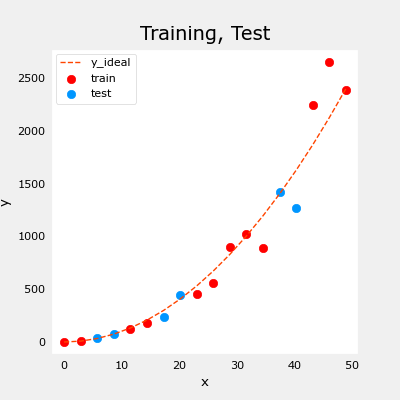

In [4]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="2.2"></a>
### 2.2 Error calculation for model evaluation, linear regression
When *evaluating* a linear regression model, you average the squared error difference of the predicted values and the target values.

$$ J_\text{test}(\mathbf{w},b) = 
            \frac{1}{2m_\text{test}}\sum_{i=0}^{m_\text{test}-1} ( f_{\mathbf{w},b}(\mathbf{x}^{(i)}_\text{test}) - y^{(i)}_\text{test} )^2 
            \tag{1}
$$

<a name="ex01"></a>
### Exercise 1

Below, create a function to evaluate the error on a data set for a linear regression model.

In [5]:
# UNQ_C1
# GRADED CELL: eval_mse
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
    ### START CODE HERE ### 
    
        err += (yhat[i] - y[i])**2
        
    err /= 2 * m
    
    ### END CODE HERE ### 
    
    return(err)

In [6]:
y_hat = np.array([2.4, 4.2])
y_tmp = np.array([2.3, 4.1])
eval_mse(y_hat, y_tmp)

# BEGIN UNIT TEST
test_eval_mse(eval_mse)   
# END UNIT TEST

 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>

    
```python
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
        err_i  = ( (yhat[i] - y[i])**2 ) 
        err   += err_i                                                                
    err = err / (2*m)                    
    return(err)
``` 

<a name="2.3"></a>
### 2.3 Compare performance on training and test data
Let's build a high degree polynomial model to minimize training error. This will use the linear_regression functions from `sklearn`. The code is in the imported utility file if you would like to see the details. The steps below are:
* create and fit the model. ('fit' is another name for training or running gradient descent).
* compute the error on the training data.
* compute the error on the test data.

In [7]:
# create a model in sklearn, train on training data
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

# predict on training data, find training error
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# predict on test data, find error
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

The computed error on the training set is substantially less than that of the test set. 

In [8]:
print(f"training err {err_train:0.2f}, test err {err_test:0.2f}")

training err 58.01, test err 171215.01


The following plot shows why this is. The model fits the training data very well. To do so, it has created a complex function. The test data was not part of the training and the model does a poor job of predicting on this data.  
This model would be described as 1) is overfitting, 2) has high variance 3) 'generalizes' poorly.

In [9]:
# x

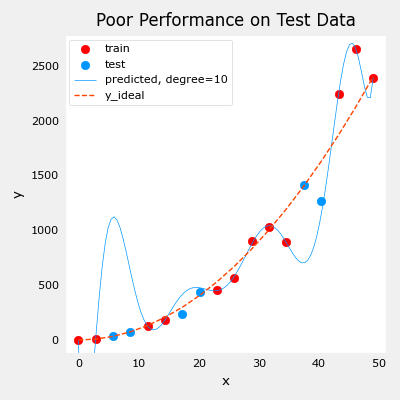

In [10]:
# plot predictions over data range 
x = np.linspace(0,int(X.max()),100)  # predict values for plot
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

The test set error shows this model will not work well on new data. If you use the test error to guide improvements in the model, then the model will perform well on the test data... but the test data was meant to represent *new* data.
You need yet another set of data to test new data performance.

The proposal made during lecture is to separate data into three groups. The distribution of training, cross-validation and test sets shown in the below table is a typical distribution, but can be varied depending on the amount of data available.

| data             | % of total | Description |
|------------------|:----------:|:---------|
| training         | 60         | Data used to tune model parameters $w$ and $b$ in training or fitting |
| cross-validation | 20         | Data used to tune other model parameters like degree of polynomial, regularization or the architecture of a neural network.|
| test             | 20         | Data used to test the model after tuning to gauge performance on new data |


Let's generate three data sets below. We'll once again use `train_test_split` from `sklearn` but will call it twice to get three splits:

In [11]:
# Generate  data
X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


<a name="3"></a>
## 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> 
 Above, it was clear the degree of the polynomial model was too high. How can you choose a good value? It turns out, as shown in the diagram, the training and cross-validation performance can provide guidance. By trying a range of degree values, the training and cross-validation performance can be evaluated. As the degree becomes too large, the cross-validation performance will start to degrade relative to the training performance. Let's try this on our example.

<a name="3.1"></a>
### 3.1 Plot Train, Cross-Validation, Test
You can see below the datapoints that will be part of training (in red) are intermixed with those that the model is not trained on (test and cv).

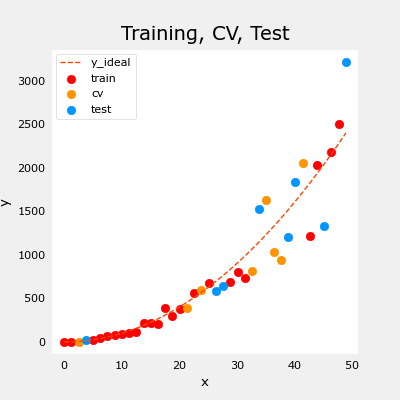

In [12]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="3.2"></a>
### 3.2 Finding the optimal degree
In previous labs, you found that you could create a model capable of fitting complex curves by utilizing a polynomial (See Course1, Week2 Feature Engineering and Polynomial Regression Lab).  Further, you demonstrated that by increasing the *degree* of the polynomial, you could *create* overfitting. (See Course 1, Week3, Over-Fitting Lab). Let's use that knowledge here to test our ability to tell the difference between over-fitting and under-fitting.

Let's train the model repeatedly, increasing the degree of the polynomial each iteration. Here, we're going to use the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) linear regression model for speed and simplicity.

In [13]:
max_degree = 9
err_train = np.zeros(max_degree)    
err_cv = np.zeros(max_degree)      
x = np.linspace(0,int(X.max()),100)  
y_pred = np.zeros((100,max_degree))  #columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:,degree] = lmodel.predict(x)
    
optimal_degree = np.argmin(err_cv)+1

<font size="4">Let's plot the result:</font>

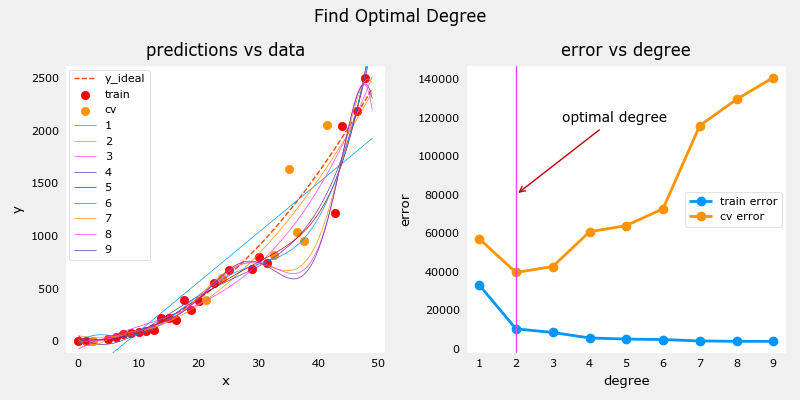

In [14]:
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_degree, max_degree)

The plot above demonstrates that separating data into two groups, data the model is trained on and data the model has not been trained on, can be used to determine if the model is underfitting or overfitting. In our example, we created a variety of models varying from underfitting to overfitting by increasing the degree of the polynomial used. 
- On the left plot, the solid lines represent the predictions from these models. A polynomial model with degree 1 produces a straight line that intersects very few data points, while the maximum degree hews very closely to every data point. 
- on the right:
    - the error on the trained data (blue) decreases as the model complexity increases as expected
    - the error of the cross-validation data decreases initially as the model starts to conform to the data, but then increases as the model starts to over-fit on the training data (fails to *generalize*).     
    
It's worth noting that the curves in these examples as not as smooth as one might draw for a lecture. It's clear the specific data points assigned to each group can change your results significantly. The general trend is what is important.

<a name="3.3"></a>
### 3.3 Tuning Regularization.
In previous labs, you have utilized *regularization* to reduce overfitting. Similar to degree, one can use the same methodology to tune the regularization parameter lambda ($\lambda$).

Let's demonstrate this by starting with a high degree polynomial and varying the regularization parameter.

In [15]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)    
err_cv = np.zeros(num_steps)       
x = np.linspace(0,int(X.max()),100) 
y_pred = np.zeros((100,num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_= lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)
    
optimal_reg_idx = np.argmin(err_cv) 

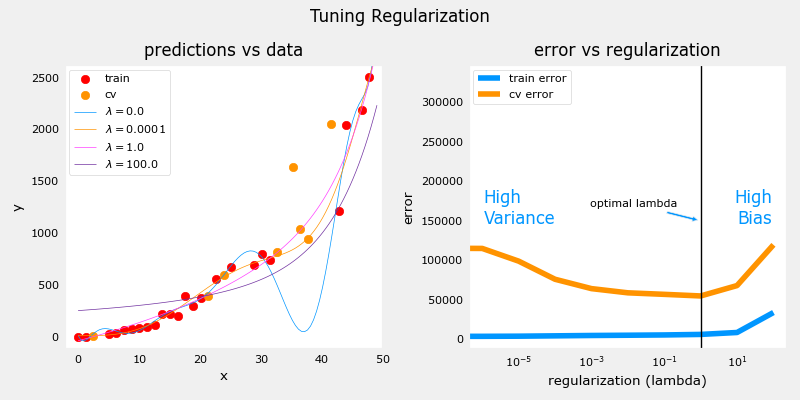

In [16]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

Above, the plots show that as regularization increases, the model moves from a high variance (overfitting) model to a high bias (underfitting) model. The vertical line in the right plot shows the optimal value of lambda. In this example, the polynomial degree was set to 10. 

<a name="3.4"></a>
### 3.4 Getting more data: Increasing Training Set Size (m)
When a model is overfitting (high variance), collecting additional data can improve performance. Let's try that here.

In [17]:
degree

10

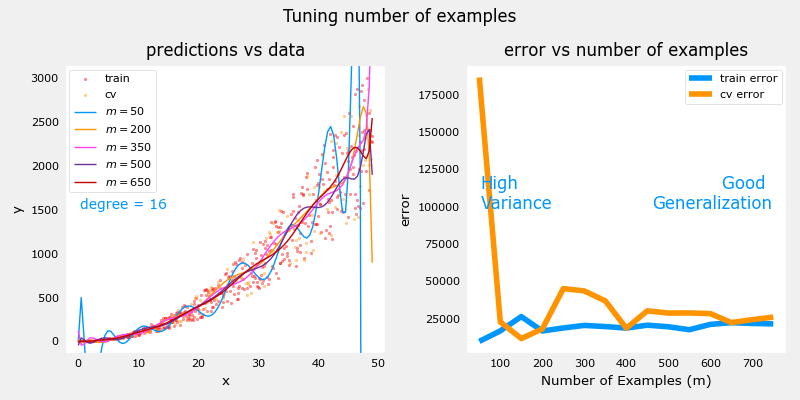

In [18]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

The above plots show that when a model has high variance and is overfitting, adding more examples improves performance. Note the curves on the left plot. The final curve with the highest value of $m$ is a smooth curve that is in the center of the data. On the right, as the number of examples increases, the performance of the training set and cross-validation set converge to similar values. Note that the curves are not as smooth as one might see in a lecture. That is to be expected. The trend remains clear: more data improves generalization. 

> Note that adding more examples when the model has high bias (underfitting) does not improve performance.


<a name="4"></a>
## 4 - Evaluating a Learning Algorithm (Neural Network)
Above, you tuned aspects of a polynomial regression model. Here, you will work with a neural network model. Let's start by creating a classification data set. 

<a name="4.1"></a>
### 4.1 Data Set
Run the cell below to generate a data set and split it into training, cross-validation (CV) and test sets. In this example, we're increasing the percentage of cross-validation data points for emphasis.  

In [19]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs()

# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


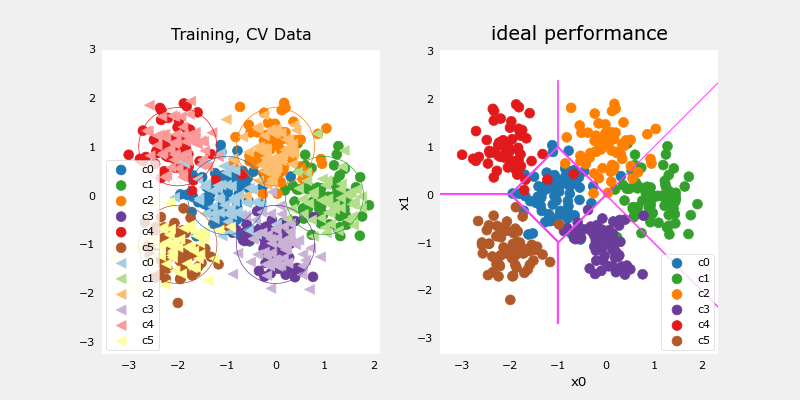

In [20]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

Above, you can see the data on the left. There are six clusters identified by color. Both training points (dots) and cross-validataion points (triangles) are shown. The interesting points are those that fall in ambiguous locations where either cluster might consider them members. What would you expect a neural network model to do? What would be an example of overfitting? underfitting?  
On the right is an example of an 'ideal' model, or a model one might create knowing the source of the data. The lines represent 'equal distance' boundaries where the distance between center points is equal. It's worth noting that this model would "misclassify" roughly 8% of the total data set.

<a name="4.2"></a>
### 4.2 Evaluating categorical model by calculating classification error
The evaluation function for categorical models used here is simply the fraction of incorrect predictions:  
$$ J_{cv} =\frac{1}{m}\sum_{i=0}^{m-1} 
\begin{cases}
    1, & \text{if $\hat{y}^{(i)} \neq y^{(i)}$}\\
    0, & \text{otherwise}
\end{cases}
$$

<a name="ex02"></a>
### Exercise 2

Below, complete the routine to calculate classification error. Note, in this lab, target values are the index of the category and are not [one-hot encoded](https://en.wikipedia.org/wiki/One-hot).

In [21]:
# UNQ_C2
# GRADED CELL: eval_cat_err
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
    ### START CODE HERE ### 
        
        if y[i] != yhat[i]:
            incorrect += 1
            
    cerr = incorrect / m
        
    ### END CODE HERE ### 
    
    return(cerr)

In [22]:
y_hat = np.array([1, 2, 0])
y_tmp = np.array([1, 2, 3])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.333" )
y_hat = np.array([[1], [2], [0], [3]])
y_tmp = np.array([[1], [2], [1], [3]])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.250" )

# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST
# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST

categorization error 0.333, expected:0.333
categorization error 0.250, expected:0.250
 All tests passed.
 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
```python
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
        if yhat[i] != y[i]:    # @REPLACE
            incorrect += 1     # @REPLACE
    cerr = incorrect/m         # @REPLACE
    return(cerr)                                    
``` 

<a name="5"></a>
## 5 - Model Complexity
Below, you will build two models. A complex model and a simple model. You will evaluate the models to determine if they are likely to overfit or underfit.

###  5.1 Complex model

<a name="ex03"></a>
### Exercise 3
Below, compose a three-layer model:
* Dense layer with 120 units, relu activation
* Dense layer with 40 units, relu activation
* Dense layer with 6 units and a linear activation (not softmax)  
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [23]:
# UNQ_C3
# GRADED CELL: model
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model = Sequential(
    [
        ### START CODE HERE ### 
        
        Dense(units=120, activation='relu'),
        Dense(units=40, activation='relu'),
        Dense(units=6, activation='linear')
  
        ### END CODE HERE ### 

    ], name="Complex"
)
model.compile(
    ### START CODE HERE ###
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.01),
    ### END CODE HERE ###
)

2023-01-07 18:26:27.576189: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
# BEGIN UNIT TEST
model.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.0212
Epoch 2/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3953
Epoch 3/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3104
Epoch 4/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2776
Epoch 5/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2719
Epoch 6/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2842
Epoch 7/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2386
Epoch 8/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2250
Epoch 9/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2317
Epoch 10/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1991
Epoch 11/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2179
Epoch 12/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2047
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 2ms/step - loss: 0.1648
Epoch 102/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1573
Epoch 103/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1864
Epoch 104/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1598
Epoch 105/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1481
Epoch 106/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1436
Epoch 107/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1666
Epoch 108/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1542
Epoch 109/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1366
Epoch 110/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1385
Epoch 111/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1483
Epoch 112/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1433
Epoch 113/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1071
Epoch 200/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1088
Epoch 201/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0884
Epoch 202/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0950
Epoch 203/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1002
Epoch 204/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1000
Epoch 205/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0983
Epoch 206/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1043
Epoch 207/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1073
Epoch 208/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1001
Epoch 209/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0957
Epoch 210/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1006
Epoch 211/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0800
Epoch 298/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0976
Epoch 299/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0846
Epoch 300/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1139
Epoch 301/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0826
Epoch 302/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0874
Epoch 303/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0827
Epoch 304/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0701
Epoch 305/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0752
Epoch 306/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0661
Epoch 307/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0688
Epoch 308/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0653
Epoch 309/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0616
Epoch 396/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0858
Epoch 397/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1061
Epoch 398/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0864
Epoch 399/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0655
Epoch 400/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0639
Epoch 401/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1018
Epoch 402/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1007
Epoch 403/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0809
Epoch 404/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0660
Epoch 405/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0718
Epoch 406/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1152
Epoch 407/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0398
Epoch 494/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0396
Epoch 495/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0353
Epoch 496/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0327
Epoch 497/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0314
Epoch 498/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0335
Epoch 499/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0312
Epoch 500/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0345
Epoch 501/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0372
Epoch 502/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0403
Epoch 503/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0420
Epoch 504/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0343
Epoch 505/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0467
Epoch 592/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0518
Epoch 593/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0628
Epoch 594/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0541
Epoch 595/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0480
Epoch 596/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0867
Epoch 597/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0776
Epoch 598/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0746
Epoch 599/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0884
Epoch 600/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0786
Epoch 601/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0681
Epoch 602/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0645
Epoch 603/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1160
Epoch 690/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0554
Epoch 691/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0434
Epoch 692/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0474
Epoch 693/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0430
Epoch 694/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0357
Epoch 695/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0338
Epoch 696/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0306
Epoch 697/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0306
Epoch 698/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0306
Epoch 699/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0306
Epoch 700/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0257
Epoch 701/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0493
Epoch 788/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0406
Epoch 789/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0415
Epoch 790/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0320
Epoch 791/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0328
Epoch 792/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0352
Epoch 793/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0278
Epoch 794/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0239
Epoch 795/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0340
Epoch 796/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0299
Epoch 797/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0311
Epoch 798/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0327
Epoch 799/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0204
Epoch 886/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0220
Epoch 887/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0229
Epoch 888/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0210
Epoch 889/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0215
Epoch 890/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0205
Epoch 891/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0217
Epoch 892/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0217
Epoch 893/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0223
Epoch 894/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0208
Epoch 895/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0204
Epoch 896/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0281
Epoch 897/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1738
Epoch 984/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2281
Epoch 985/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2391
Epoch 986/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1360
Epoch 987/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0960
Epoch 988/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0843
Epoch 989/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0565
Epoch 990/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0518
Epoch 991/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0547
Epoch 992/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0649
Epoch 993/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0677
Epoch 994/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0485
Epoch 995/1000
13/1

In [25]:
# BEGIN UNIT TEST
model.summary()

model_test(model, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "Complex"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               360       
                                                                 
 dense_1 (Dense)             (None, 40)                4840      
                                                                 
 dense_2 (Dense)             (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Complex"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model = Sequential(
    [
        Dense(120, activation = 'relu', name = "L1"),      
        Dense(40, activation = 'relu', name = "L2"),         
        Dense(classes, activation = 'linear', name = "L3")  
    ], name="Complex"
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),          
    optimizer=tf.keras.optimizers.Adam(0.01),   
)

model.fit(
    X_train,y_train,
    epochs=1000
)                                  
``` 

1082/1082 [==============================] - 1s 760us/step


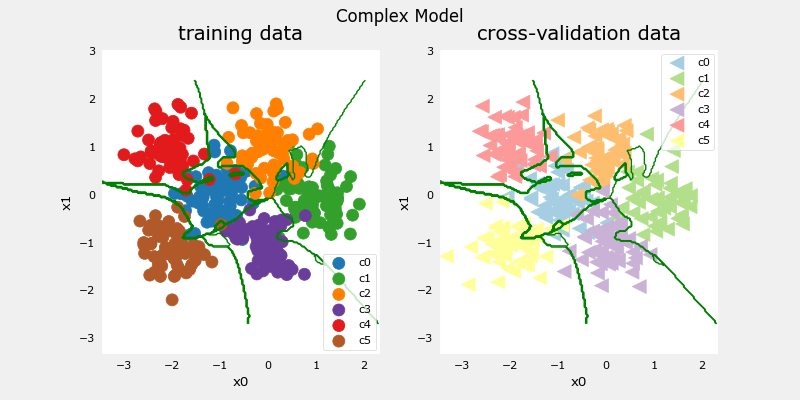

In [26]:
#make a model for plotting routines to call
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

This model has worked very hard to capture outliers of each category. As a result, it has miscategorized some of the cross-validation data. Let's calculate the classification error.

In [27]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

10/10 [==============================] - 0s 1ms/step
categorization error, training, complex model: 0.015
categorization error, cv,       complex model: 0.103


<a name="5.1"></a>
### 5.1 Simple model
Now, let's try a simple model

<a name="ex04"></a>
### Exercise 4

Below, compose a two-layer model:
* Dense layer with 6 units, relu activation
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [28]:
# UNQ_C4
# GRADED CELL: model_s

tf.random.set_seed(1234)
model_s = Sequential(
    [
        ### START CODE HERE ###
        
        Dense(units=6, activation='relu'),
        Dense(units=6, activation='linear')
        
        ### END CODE HERE ###
    ], name = "Simple"
)
model_s.compile(
    ### START CODE HERE ### 
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.01),
    ### START CODE HERE ### 
)


In [29]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# BEGIN UNIT TEST
model_s.fit(
    X_train,y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.6681
Epoch 2/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.4046
Epoch 3/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.1903
Epoch 4/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.0045
Epoch 5/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.8579
Epoch 6/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.7405
Epoch 7/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6589
Epoch 8/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5933
Epoch 9/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5428
Epoch 10/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5005
Epoch 11/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4650
Epoch 12/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4349
Epoch 13/1000
13/13 [====

Epoch 101/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1953
Epoch 102/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1962
Epoch 103/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1986
Epoch 104/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1941
Epoch 105/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1923
Epoch 106/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1923
Epoch 107/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1918
Epoch 108/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1921
Epoch 109/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1935
Epoch 110/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1931
Epoch 111/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1913
Epoch 112/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1934
Epoc

13/13 [==============================] - 0s 1ms/step - loss: 0.1896
Epoch 200/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1866
Epoch 201/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1872
Epoch 202/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1849
Epoch 203/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1862
Epoch 204/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1876
Epoch 205/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1855
Epoch 206/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1881
Epoch 207/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1849
Epoch 208/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1887
Epoch 209/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1856
Epoch 210/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1855
Epoch 211/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1837
Epoch 298/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1835
Epoch 299/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1793
Epoch 300/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1813
Epoch 301/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1801
Epoch 302/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1837
Epoch 303/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1789
Epoch 304/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1847
Epoch 305/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1798
Epoch 306/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1803
Epoch 307/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1802
Epoch 308/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1793
Epoch 309/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1707
Epoch 396/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1753
Epoch 397/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1751
Epoch 398/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1729
Epoch 399/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1728
Epoch 400/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1743
Epoch 401/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1727
Epoch 402/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1724
Epoch 403/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1720
Epoch 404/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1725
Epoch 405/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1711
Epoch 406/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1710
Epoch 407/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1717
Epoch 494/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1700
Epoch 495/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1688
Epoch 496/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1706
Epoch 497/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1678
Epoch 498/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1680
Epoch 499/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1682
Epoch 500/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1680
Epoch 501/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1724
Epoch 502/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1699
Epoch 503/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1718
Epoch 504/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1682
Epoch 505/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1695
Epoch 592/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1679
Epoch 593/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1693
Epoch 594/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1666
Epoch 595/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1692
Epoch 596/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1661
Epoch 597/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1670
Epoch 598/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1672
Epoch 599/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1658
Epoch 600/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1681
Epoch 601/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1665
Epoch 602/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1674
Epoch 603/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1675
Epoch 690/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1657
Epoch 691/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1664
Epoch 692/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1657
Epoch 693/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1666
Epoch 694/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1660
Epoch 695/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1659
Epoch 696/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1659
Epoch 697/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1665
Epoch 698/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1662
Epoch 699/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1652
Epoch 700/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1676
Epoch 701/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1682
Epoch 788/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1639
Epoch 789/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1661
Epoch 790/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1686
Epoch 791/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1640
Epoch 792/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1642
Epoch 793/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1678
Epoch 794/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1696
Epoch 795/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1659
Epoch 796/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1689
Epoch 797/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1651
Epoch 798/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1677
Epoch 799/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1647
Epoch 886/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1641
Epoch 887/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1655
Epoch 888/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1655
Epoch 889/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1642
Epoch 890/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1662
Epoch 891/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1643
Epoch 892/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1649
Epoch 893/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1647
Epoch 894/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1650
Epoch 895/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1653
Epoch 896/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1651
Epoch 897/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1635
Epoch 984/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1635
Epoch 985/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1631
Epoch 986/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1652
Epoch 987/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1629
Epoch 988/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1649
Epoch 989/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1642
Epoch 990/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1634
Epoch 991/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1637
Epoch 992/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1642
Epoch 993/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1633
Epoch 994/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1623
Epoch 995/1000
13/1

In [30]:
# BEGIN UNIT TEST
model_s.summary()

model_s_test(model_s, classes, X_train.shape[1])
# END UNIT TEST

Model: "Simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6)                 18        
                                                                 
 dense_4 (Dense)             (None, 6)                 42        
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 6)                 18        
_________________________________________________________________
L2 (Dense)                   (None, 6)                 42        
=================================================================
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_s = Sequential(
    [
        Dense(6, activation = 'relu', name="L1"),            # @REPLACE
        Dense(classes, activation = 'linear', name="L2")     # @REPLACE
    ], name = "Simple"
)
model_s.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),     # @REPLACE
    optimizer=tf.keras.optimizers.Adam(0.01),     # @REPLACE
)

model_s.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

1082/1082 [==============================] - 1s 752us/step


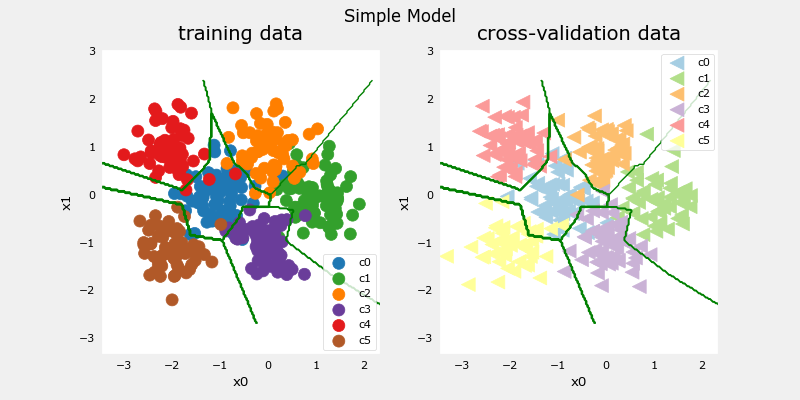

In [31]:
#make a model for plotting routines to call
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

This simple models does pretty well. Let's calculate the classification error.

In [32]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

10/10 [==============================] - 0s 954us/step
categorization error, training, simple model, 0.062, complex model: 0.015
categorization error, cv,       simple model, 0.087, complex model: 0.103


Our simple model has a little higher classification error on training data but does better on cross-validation data than the more complex model.

<a name="6"></a>
## 6 - Regularization
As in the case of polynomial regression, one can apply regularization to moderate the impact of a more complex model. Let's try this below.

<a name="ex05"></a>
### Exercise 5

Reconstruct your complex model, but this time include regularization.
Below, compose a three-layer model:
* Dense layer with 120 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 40 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [33]:
# UNQ_C5
# GRADED CELL: model_r

tf.random.set_seed(1234)
model_r = Sequential(
    [
        ### START CODE HERE ###
        
        Dense(units=120, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        Dense(units=40, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        Dense(units=6, activation='linear')
        
        ### START CODE HERE ###
    ], name= "Reg"
)
model_r.compile(
    ### START CODE HERE ### 
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.01),
    ### START CODE HERE ### 
)


In [34]:
# BEGIN UNIT TEST
model_r.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 2ms/step - loss: 4.4870
Epoch 2/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.6505
Epoch 3/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.2926
Epoch 4/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.0372
Epoch 5/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9666
Epoch 6/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9502
Epoch 7/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9295
Epoch 8/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.8693
Epoch 9/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.7945
Epoch 10/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.7542
Epoch 11/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.7470
Epoch 12/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.7494
Epoch 13/1000
13/13 [====

Epoch 101/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4781
Epoch 102/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4600
Epoch 103/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4631
Epoch 104/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4517
Epoch 105/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4985
Epoch 106/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4680
Epoch 107/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4583
Epoch 108/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4643
Epoch 109/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4525
Epoch 110/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4483
Epoch 111/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4516
Epoch 112/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4424
Epoc

13/13 [==============================] - 0s 2ms/step - loss: 0.4005
Epoch 200/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4031
Epoch 201/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4254
Epoch 202/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3924
Epoch 203/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3906
Epoch 204/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4029
Epoch 205/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4545
Epoch 206/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4324
Epoch 207/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4043
Epoch 208/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4091
Epoch 209/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4302
Epoch 210/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4110
Epoch 211/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3792
Epoch 298/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3873
Epoch 299/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3891
Epoch 300/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4240
Epoch 301/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3935
Epoch 302/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3895
Epoch 303/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3822
Epoch 304/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3751
Epoch 305/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3746
Epoch 306/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3835
Epoch 307/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3887
Epoch 308/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3832
Epoch 309/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3870
Epoch 396/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3738
Epoch 397/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3834
Epoch 398/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3711
Epoch 399/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3673
Epoch 400/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3649
Epoch 401/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3487
Epoch 402/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3528
Epoch 403/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3523
Epoch 404/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3552
Epoch 405/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3462
Epoch 406/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3526
Epoch 407/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3439
Epoch 494/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3451
Epoch 495/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3435
Epoch 496/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3684
Epoch 497/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3938
Epoch 498/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3408
Epoch 499/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3355
Epoch 500/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3548
Epoch 501/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3473
Epoch 502/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3512
Epoch 503/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3804
Epoch 504/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3589
Epoch 505/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3395
Epoch 592/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3363
Epoch 593/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3324
Epoch 594/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3330
Epoch 595/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4114
Epoch 596/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3882
Epoch 597/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3476
Epoch 598/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3377
Epoch 599/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3301
Epoch 600/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3479
Epoch 601/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3281
Epoch 602/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3385
Epoch 603/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3904
Epoch 690/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.3717
Epoch 691/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3370
Epoch 692/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3528
Epoch 693/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3644
Epoch 694/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3454
Epoch 695/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3306
Epoch 696/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3314
Epoch 697/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3322
Epoch 698/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3433
Epoch 699/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3355
Epoch 700/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3401
Epoch 701/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3295
Epoch 788/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3215
Epoch 789/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3306
Epoch 790/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3287
Epoch 791/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3693
Epoch 792/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3679
Epoch 793/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3481
Epoch 794/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3550
Epoch 795/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3531
Epoch 796/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3652
Epoch 797/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3512
Epoch 798/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3790
Epoch 799/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3541
Epoch 886/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3383
Epoch 887/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3168
Epoch 888/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3398
Epoch 889/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3334
Epoch 890/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3726
Epoch 891/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3216
Epoch 892/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3254
Epoch 893/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3337
Epoch 894/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3416
Epoch 895/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3875
Epoch 896/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3502
Epoch 897/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3104
Epoch 984/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3252
Epoch 985/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3427
Epoch 986/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3452
Epoch 987/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3468
Epoch 988/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3135
Epoch 989/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3294
Epoch 990/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3394
Epoch 991/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3317
Epoch 992/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3410
Epoch 993/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3190
Epoch 994/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3191
Epoch 995/1000
13/1

In [35]:
# BEGIN UNIT TEST
model_r.summary()

model_r_test(model_r, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "Reg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 120)               360       
                                                                 
 dense_6 (Dense)             (None, 40)                4840      
                                                                 
 dense_7 (Dense)             (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
ddd
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "ComplexRegularized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_r = Sequential(
    [
        Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L1"), 
        Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L2"),  
        Dense(classes, activation = 'linear', name="L3")  
    ], name="ComplexRegularized"
)
model_r.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(0.01),                             
)

model_r.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

1082/1082 [==============================] - 1s 755us/step


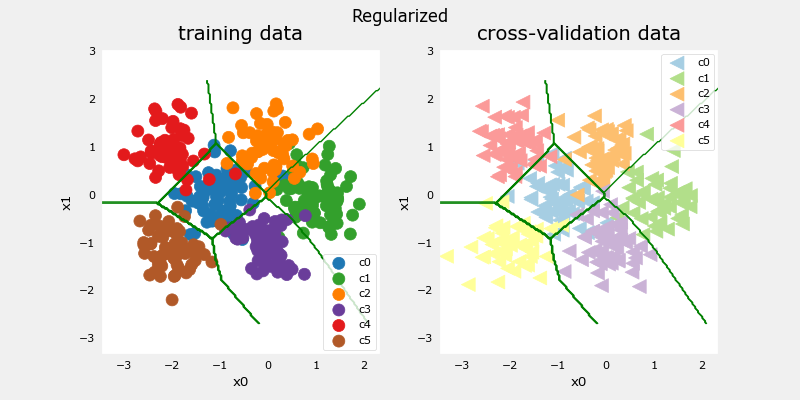

In [36]:
#make a model for plotting routines to call
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)
 
plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized")

The results look very similar to the 'ideal' model. Let's check classification error.

In [37]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

3/3 [==============================] - 0s 2ms/step
categorization error, training, regularized: 0.068, simple model, 0.062, complex model: 0.015
categorization error, cv,       regularized: 0.066, simple model, 0.087, complex model: 0.103


The simple model is a bit better in the training set than the regularized model but is worse in the cross validation set.

<a name="7"></a>
## 7 - Iterate to find optimal regularization value
As you did in linear regression, you can try many regularization values. This code takes several minutes to run. If you have time, you can run it and check the results. If not, you have completed the graded parts of the assignment!

In [38]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)
for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f"Finished lambda = {lambda_}")


Epoch 1/1000
13/13 [==============================] - 0s 2ms/step - loss: 1.0398
Epoch 2/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3685
Epoch 3/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2896
Epoch 4/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2629
Epoch 5/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2628
Epoch 6/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2783
Epoch 7/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2424
Epoch 8/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2267
Epoch 9/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2311
Epoch 10/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2039
Epoch 11/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2134
Epoch 12/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2052
Epoch 13/1000
13/13 [====

13/13 [==============================] - 0s 2ms/step - loss: 0.1642
Epoch 102/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1603
Epoch 103/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1815
Epoch 104/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1615
Epoch 105/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1448
Epoch 106/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1364
Epoch 107/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1502
Epoch 108/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1426
Epoch 109/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1474
Epoch 110/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1389
Epoch 111/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1461
Epoch 112/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1590
Epoch 113/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1069
Epoch 200/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1076
Epoch 201/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0990
Epoch 202/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0941
Epoch 203/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0951
Epoch 204/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1053
Epoch 205/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1030
Epoch 206/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1088
Epoch 207/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1522
Epoch 208/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1228
Epoch 209/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1261
Epoch 210/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1188
Epoch 211/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0831
Epoch 298/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0737
Epoch 299/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0678
Epoch 300/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0776
Epoch 301/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0652
Epoch 302/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0746
Epoch 303/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0723
Epoch 304/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0648
Epoch 305/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0712
Epoch 306/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0673
Epoch 307/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0757
Epoch 308/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0669
Epoch 309/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0571
Epoch 396/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0509
Epoch 397/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0541
Epoch 398/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0555
Epoch 399/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0611
Epoch 400/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0802
Epoch 401/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0763
Epoch 402/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0803
Epoch 403/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0550
Epoch 404/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0517
Epoch 405/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0489
Epoch 406/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0501
Epoch 407/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0422
Epoch 494/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0385
Epoch 495/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0356
Epoch 496/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0364
Epoch 497/1000
13/13 [==============================] - 0s 9ms/step - loss: 0.0350
Epoch 498/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0436
Epoch 499/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0383
Epoch 500/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0370
Epoch 501/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0410
Epoch 502/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0391
Epoch 503/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0342
Epoch 504/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0358
Epoch 505/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0382
Epoch 592/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0381
Epoch 593/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0548
Epoch 594/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0429
Epoch 595/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0339
Epoch 596/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.0319
Epoch 597/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0312
Epoch 598/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0301
Epoch 599/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0280
Epoch 600/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0303
Epoch 601/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0324
Epoch 602/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0326
Epoch 603/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1477
Epoch 690/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0916
Epoch 691/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0850
Epoch 692/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0618
Epoch 693/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0630
Epoch 694/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0585
Epoch 695/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0731
Epoch 696/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0531
Epoch 697/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0536
Epoch 698/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0423
Epoch 699/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0437
Epoch 700/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0378
Epoch 701/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0281
Epoch 788/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0282
Epoch 789/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0273
Epoch 790/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0286
Epoch 791/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0354
Epoch 792/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0313
Epoch 793/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0254
Epoch 794/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0248
Epoch 795/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0225
Epoch 796/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0262
Epoch 797/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0258
Epoch 798/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0241
Epoch 799/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0253
Epoch 886/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0257
Epoch 887/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0278
Epoch 888/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0279
Epoch 889/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0322
Epoch 890/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0332
Epoch 891/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0332
Epoch 892/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0249
Epoch 893/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0251
Epoch 894/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0251
Epoch 895/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0217
Epoch 896/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0220
Epoch 897/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.0402
Epoch 984/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0380
Epoch 985/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0390
Epoch 986/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0429
Epoch 987/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0433
Epoch 988/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0441
Epoch 989/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0417
Epoch 990/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0415
Epoch 991/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0389
Epoch 992/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0378
Epoch 993/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0366
Epoch 994/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0367
Epoch 995/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2496
Epoch 83/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2293
Epoch 84/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2310
Epoch 85/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2596
Epoch 86/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2390
Epoch 87/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2319
Epoch 88/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2480
Epoch 89/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2407
Epoch 90/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2348
Epoch 91/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2250
Epoch 92/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2225
Epoch 93/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2268
Epoch 94/1000
13/13 [=========

13/13 [==============================] - 0s 2ms/step - loss: 0.2182
Epoch 182/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2053
Epoch 183/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2042
Epoch 184/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2082
Epoch 185/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2108
Epoch 186/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2028
Epoch 187/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2062
Epoch 188/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2070
Epoch 189/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2027
Epoch 190/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2138
Epoch 191/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2163
Epoch 192/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2041
Epoch 193/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1995
Epoch 280/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1993
Epoch 281/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1986
Epoch 282/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1909
Epoch 283/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1984
Epoch 284/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1892
Epoch 285/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1883
Epoch 286/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1937
Epoch 287/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1917
Epoch 288/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2148
Epoch 289/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2050
Epoch 290/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2046
Epoch 291/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1822
Epoch 378/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1852
Epoch 379/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1875
Epoch 380/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1823
Epoch 381/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1849
Epoch 382/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1890
Epoch 383/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1979
Epoch 384/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1910
Epoch 385/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1787
Epoch 386/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1832
Epoch 387/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1843
Epoch 388/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1834
Epoch 389/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1918
Epoch 476/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1847
Epoch 477/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1843
Epoch 478/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1920
Epoch 479/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1790
Epoch 480/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1831
Epoch 481/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1788
Epoch 482/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1800
Epoch 483/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1828
Epoch 484/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1855
Epoch 485/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1780
Epoch 486/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1725
Epoch 487/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1728
Epoch 574/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1709
Epoch 575/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1672
Epoch 576/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1659
Epoch 577/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1721
Epoch 578/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1794
Epoch 579/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1669
Epoch 580/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1761
Epoch 581/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1682
Epoch 582/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1658
Epoch 583/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1733
Epoch 584/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1820
Epoch 585/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1761
Epoch 672/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1794
Epoch 673/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1679
Epoch 674/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1744
Epoch 675/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1710
Epoch 676/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1661
Epoch 677/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1645
Epoch 678/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1694
Epoch 679/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1779
Epoch 680/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1770
Epoch 681/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1669
Epoch 682/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1720
Epoch 683/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1543
Epoch 770/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1575
Epoch 771/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1644
Epoch 772/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1564
Epoch 773/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1627
Epoch 774/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1699
Epoch 775/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1743
Epoch 776/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1588
Epoch 777/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1613
Epoch 778/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1680
Epoch 779/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1620
Epoch 780/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1608
Epoch 781/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1525
Epoch 868/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1564
Epoch 869/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1614
Epoch 870/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1678
Epoch 871/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1675
Epoch 872/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1510
Epoch 873/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1522
Epoch 874/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1490
Epoch 875/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1557
Epoch 876/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1517
Epoch 877/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1552
Epoch 878/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1607
Epoch 879/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.1678
Epoch 966/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1589
Epoch 967/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1728
Epoch 968/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1994
Epoch 969/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1801
Epoch 970/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1690
Epoch 971/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1609
Epoch 972/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1589
Epoch 973/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1591
Epoch 974/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1616
Epoch 975/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1532
Epoch 976/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1467
Epoch 977/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3405
Epoch 65/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3524
Epoch 66/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3305
Epoch 67/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3509
Epoch 68/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3530
Epoch 69/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3241
Epoch 70/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3164
Epoch 71/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3230
Epoch 72/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2922
Epoch 73/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2990
Epoch 74/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3078
Epoch 75/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3233
Epoch 76/1000
13/13 [=========

13/13 [==============================] - 0s 3ms/step - loss: 0.2853
Epoch 164/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2929
Epoch 165/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2787
Epoch 166/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2752
Epoch 167/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2700
Epoch 168/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2778
Epoch 169/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2713
Epoch 170/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2737
Epoch 171/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2717
Epoch 172/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2631
Epoch 173/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2831
Epoch 174/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2824
Epoch 175/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2726
Epoch 262/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2671
Epoch 263/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2608
Epoch 264/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2557
Epoch 265/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2687
Epoch 266/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2734
Epoch 267/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2638
Epoch 268/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2593
Epoch 269/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2553
Epoch 270/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2648
Epoch 271/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2593
Epoch 272/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2634
Epoch 273/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2524
Epoch 360/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2737
Epoch 361/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2592
Epoch 362/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2848
Epoch 363/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2759
Epoch 364/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2597
Epoch 365/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2611
Epoch 366/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2692
Epoch 367/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2697
Epoch 368/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2521
Epoch 369/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2529
Epoch 370/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2536
Epoch 371/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2383
Epoch 458/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2549
Epoch 459/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2447
Epoch 460/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2436
Epoch 461/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2672
Epoch 462/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2420
Epoch 463/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2378
Epoch 464/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2459
Epoch 465/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2562
Epoch 466/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2588
Epoch 467/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2522
Epoch 468/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2495
Epoch 469/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2460
Epoch 556/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2339
Epoch 557/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2353
Epoch 558/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2413
Epoch 559/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.2532
Epoch 560/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2543
Epoch 561/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2397
Epoch 562/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2612
Epoch 563/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2348
Epoch 564/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2424
Epoch 565/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2428
Epoch 566/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2456
Epoch 567/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2292
Epoch 654/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2476
Epoch 655/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2345
Epoch 656/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2355
Epoch 657/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2319
Epoch 658/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2486
Epoch 659/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2391
Epoch 660/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2401
Epoch 661/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2276
Epoch 662/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2433
Epoch 663/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2331
Epoch 664/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2508
Epoch 665/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2354
Epoch 752/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2432
Epoch 753/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2259
Epoch 754/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2424
Epoch 755/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2317
Epoch 756/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2457
Epoch 757/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2413
Epoch 758/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2356
Epoch 759/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2330
Epoch 760/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2405
Epoch 761/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2439
Epoch 762/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2341
Epoch 763/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2312
Epoch 850/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2252
Epoch 851/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2334
Epoch 852/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2560
Epoch 853/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2469
Epoch 854/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2476
Epoch 855/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2392
Epoch 856/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2287
Epoch 857/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2370
Epoch 858/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2346
Epoch 859/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2377
Epoch 860/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2350
Epoch 861/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.2321
Epoch 948/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2372
Epoch 949/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2261
Epoch 950/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2203
Epoch 951/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2344
Epoch 952/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2462
Epoch 953/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2401
Epoch 954/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2442
Epoch 955/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2301
Epoch 956/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2317
Epoch 957/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2356
Epoch 958/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2418
Epoch 959/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4551
Epoch 47/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4289
Epoch 48/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4808
Epoch 49/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4670
Epoch 50/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4309
Epoch 51/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4473
Epoch 52/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4374
Epoch 53/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4499
Epoch 54/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4280
Epoch 55/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4524
Epoch 56/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4202
Epoch 57/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4348
Epoch 58/1000
13/13 [=========

13/13 [==============================] - 0s 2ms/step - loss: 0.3591
Epoch 146/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3553
Epoch 147/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3721
Epoch 148/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3575
Epoch 149/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3565
Epoch 150/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3532
Epoch 151/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3548
Epoch 152/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3481
Epoch 153/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3722
Epoch 154/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3510
Epoch 155/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3529
Epoch 156/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3579
Epoch 157/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3283
Epoch 244/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3390
Epoch 245/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3381
Epoch 246/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3342
Epoch 247/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3270
Epoch 248/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3444
Epoch 249/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3537
Epoch 250/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3402
Epoch 251/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3612
Epoch 252/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3371
Epoch 253/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3351
Epoch 254/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3555
Epoch 255/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3241
Epoch 342/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3360
Epoch 343/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3238
Epoch 344/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3177
Epoch 345/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3177
Epoch 346/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3253
Epoch 347/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3307
Epoch 348/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3378
Epoch 349/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3076
Epoch 350/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3310
Epoch 351/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3143
Epoch 352/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3371
Epoch 353/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3033
Epoch 440/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3016
Epoch 441/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3122
Epoch 442/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3236
Epoch 443/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3157
Epoch 444/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3091
Epoch 445/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3200
Epoch 446/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3092
Epoch 447/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3341
Epoch 448/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3247
Epoch 449/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3052
Epoch 450/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3080
Epoch 451/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3623
Epoch 538/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3235
Epoch 539/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2951
Epoch 540/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3155
Epoch 541/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3270
Epoch 542/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3300
Epoch 543/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3187
Epoch 544/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3108
Epoch 545/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3039
Epoch 546/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3205
Epoch 547/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3314
Epoch 548/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3123
Epoch 549/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3296
Epoch 636/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3491
Epoch 637/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3066
Epoch 638/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3001
Epoch 639/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2942
Epoch 640/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2954
Epoch 641/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2904
Epoch 642/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3086
Epoch 643/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3180
Epoch 644/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2943
Epoch 645/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3120
Epoch 646/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3219
Epoch 647/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3013
Epoch 734/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3176
Epoch 735/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3132
Epoch 736/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3197
Epoch 737/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3273
Epoch 738/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3001
Epoch 739/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3034
Epoch 740/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3121
Epoch 741/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3298
Epoch 742/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3597
Epoch 743/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3005
Epoch 744/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2954
Epoch 745/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3188
Epoch 832/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3278
Epoch 833/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3205
Epoch 834/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3020
Epoch 835/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2904
Epoch 836/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2853
Epoch 837/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2981
Epoch 838/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3029
Epoch 839/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2956
Epoch 840/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3123
Epoch 841/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2851
Epoch 842/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3103
Epoch 843/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2996
Epoch 930/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3075
Epoch 931/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3073
Epoch 932/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2992
Epoch 933/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2985
Epoch 934/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3261
Epoch 935/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3046
Epoch 936/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2928
Epoch 937/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2902
Epoch 938/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3051
Epoch 939/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2888
Epoch 940/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.2884
Epoch 941/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.6144
Epoch 29/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6055
Epoch 30/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6335
Epoch 31/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6316
Epoch 32/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6342
Epoch 33/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6278
Epoch 34/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6558
Epoch 35/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6394
Epoch 36/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6124
Epoch 37/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5877
Epoch 38/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5731
Epoch 39/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5694
Epoch 40/1000
13/13 [=========

13/13 [==============================] - 0s 2ms/step - loss: 0.4455
Epoch 128/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4348
Epoch 129/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4446
Epoch 130/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4366
Epoch 131/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4527
Epoch 132/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4321
Epoch 133/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4250
Epoch 134/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4476
Epoch 135/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4445
Epoch 136/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4486
Epoch 137/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4279
Epoch 138/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4457
Epoch 139/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4350
Epoch 226/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4256
Epoch 227/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4413
Epoch 228/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3939
Epoch 229/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4036
Epoch 230/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4132
Epoch 231/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4030
Epoch 232/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4140
Epoch 233/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3937
Epoch 234/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3884
Epoch 235/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3918
Epoch 236/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3979
Epoch 237/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4028
Epoch 324/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4022
Epoch 325/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3965
Epoch 326/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3867
Epoch 327/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3784
Epoch 328/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3943
Epoch 329/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3786
Epoch 330/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3672
Epoch 331/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3709
Epoch 332/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3740
Epoch 333/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4068
Epoch 334/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3948
Epoch 335/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3838
Epoch 422/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3973
Epoch 423/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3746
Epoch 424/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3755
Epoch 425/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3662
Epoch 426/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3639
Epoch 427/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3658
Epoch 428/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3736
Epoch 429/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3718
Epoch 430/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3626
Epoch 431/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3536
Epoch 432/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3597
Epoch 433/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3682
Epoch 520/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3657
Epoch 521/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3463
Epoch 522/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3651
Epoch 523/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3766
Epoch 524/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3430
Epoch 525/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3495
Epoch 526/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3555
Epoch 527/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3435
Epoch 528/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3485
Epoch 529/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3792
Epoch 530/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3675
Epoch 531/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3296
Epoch 618/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3662
Epoch 619/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3909
Epoch 620/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3893
Epoch 621/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3497
Epoch 622/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3511
Epoch 623/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3430
Epoch 624/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3331
Epoch 625/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3325
Epoch 626/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3454
Epoch 627/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3561
Epoch 628/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3698
Epoch 629/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3307
Epoch 716/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3357
Epoch 717/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3493
Epoch 718/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3670
Epoch 719/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3929
Epoch 720/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3847
Epoch 721/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3920
Epoch 722/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3764
Epoch 723/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3918
Epoch 724/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3861
Epoch 725/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3801
Epoch 726/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3609
Epoch 727/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3400
Epoch 814/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3463
Epoch 815/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3489
Epoch 816/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3419
Epoch 817/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3628
Epoch 818/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3448
Epoch 819/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3276
Epoch 820/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3649
Epoch 821/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3911
Epoch 822/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3462
Epoch 823/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3414
Epoch 824/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3510
Epoch 825/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3267
Epoch 912/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3282
Epoch 913/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3224
Epoch 914/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3519
Epoch 915/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3460
Epoch 916/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3492
Epoch 917/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3421
Epoch 918/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3391
Epoch 919/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3533
Epoch 920/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3773
Epoch 921/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3414
Epoch 922/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3398
Epoch 923/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 1.0260
Epoch 10/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9907
Epoch 11/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9646
Epoch 12/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9487
Epoch 13/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9380
Epoch 14/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.9302
Epoch 15/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.8955
Epoch 16/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.8929
Epoch 17/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.8983
Epoch 18/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.8883
Epoch 19/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.8679
Epoch 20/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.8564
Epoch 21/1000
13/13 [=========

Epoch 109/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5648
Epoch 110/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5580
Epoch 111/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5558
Epoch 112/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5486
Epoch 113/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5429
Epoch 114/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5417
Epoch 115/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5417
Epoch 116/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5468
Epoch 117/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5783
Epoch 118/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5729
Epoch 119/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5704
Epoch 120/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5590
Epoc

13/13 [==============================] - 0s 2ms/step - loss: 0.5087
Epoch 208/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5184
Epoch 209/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5287
Epoch 210/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4952
Epoch 211/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4935
Epoch 212/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4818
Epoch 213/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4802
Epoch 214/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4778
Epoch 215/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4843
Epoch 216/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4961
Epoch 217/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4867
Epoch 218/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4846
Epoch 219/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4530
Epoch 306/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4776
Epoch 307/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4585
Epoch 308/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4439
Epoch 309/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4512
Epoch 310/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4475
Epoch 311/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4410
Epoch 312/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4451
Epoch 313/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4513
Epoch 314/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4531
Epoch 315/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4444
Epoch 316/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4388
Epoch 317/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4290
Epoch 404/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4386
Epoch 405/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4286
Epoch 406/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4287
Epoch 407/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4402
Epoch 408/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4745
Epoch 409/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4232
Epoch 410/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4363
Epoch 411/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4709
Epoch 412/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4232
Epoch 413/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4348
Epoch 414/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4495
Epoch 415/1000
13/1

13/13 [==============================] - 0s 4ms/step - loss: 0.4056
Epoch 502/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4137
Epoch 503/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4451
Epoch 504/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4603
Epoch 505/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4518
Epoch 506/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4570
Epoch 507/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4492
Epoch 508/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4041
Epoch 509/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4143
Epoch 510/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4082
Epoch 511/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4202
Epoch 512/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4223
Epoch 513/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3921
Epoch 600/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4068
Epoch 601/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3907
Epoch 602/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4009
Epoch 603/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3919
Epoch 604/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3922
Epoch 605/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4006
Epoch 606/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4234
Epoch 607/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4089
Epoch 608/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4139
Epoch 609/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3895
Epoch 610/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4065
Epoch 611/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3899
Epoch 698/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4018
Epoch 699/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3982
Epoch 700/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3914
Epoch 701/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3886
Epoch 702/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3816
Epoch 703/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3721
Epoch 704/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3990
Epoch 705/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3912
Epoch 706/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3996
Epoch 707/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4061
Epoch 708/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3986
Epoch 709/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4363
Epoch 796/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4428
Epoch 797/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3775
Epoch 798/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3899
Epoch 799/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3844
Epoch 800/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3840
Epoch 801/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3768
Epoch 802/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3748
Epoch 803/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3696
Epoch 804/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3641
Epoch 805/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3824
Epoch 806/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3835
Epoch 807/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3820
Epoch 894/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3741
Epoch 895/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4240
Epoch 896/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3910
Epoch 897/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3877
Epoch 898/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3843
Epoch 899/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.4117
Epoch 900/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3953
Epoch 901/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4264
Epoch 902/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4183
Epoch 903/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4155
Epoch 904/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3715
Epoch 905/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.3832
Epoch 992/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3590
Epoch 993/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3697
Epoch 994/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3769
Epoch 995/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3780
Epoch 996/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3706
Epoch 997/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4063
Epoch 998/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3687
Epoch 999/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3839
Epoch 1000/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3802
Finished lambda = 0.2
Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 9.7814
Epoch 2/1000
13/13 [==============================] - 0s 2ms/step - loss: 2.2887


13/13 [==============================] - 0s 2ms/step - loss: 0.6936
Epoch 91/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6970
Epoch 92/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6822
Epoch 93/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6792
Epoch 94/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6737
Epoch 95/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6816
Epoch 96/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6666
Epoch 97/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6671
Epoch 98/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.6795
Epoch 99/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.7013
Epoch 100/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.7076
Epoch 101/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6995
Epoch 102/1000
13/13 [======

Epoch 189/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5778
Epoch 190/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5711
Epoch 191/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5883
Epoch 192/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5849
Epoch 193/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5730
Epoch 194/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5645
Epoch 195/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5662
Epoch 196/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5609
Epoch 197/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5742
Epoch 198/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5641
Epoch 199/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5703
Epoch 200/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5702
Epoc

13/13 [==============================] - 0s 2ms/step - loss: 0.5698
Epoch 288/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5659
Epoch 289/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5329
Epoch 290/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5337
Epoch 291/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5381
Epoch 292/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5182
Epoch 293/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5262
Epoch 294/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5290
Epoch 295/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5583
Epoch 296/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5300
Epoch 297/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5207
Epoch 298/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5229
Epoch 299/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.5017
Epoch 386/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4839
Epoch 387/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5009
Epoch 388/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5077
Epoch 389/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4984
Epoch 390/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4851
Epoch 391/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4895
Epoch 392/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4923
Epoch 393/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4876
Epoch 394/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4874
Epoch 395/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5161
Epoch 396/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5325
Epoch 397/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.5157
Epoch 484/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4739
Epoch 485/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5017
Epoch 486/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4793
Epoch 487/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4758
Epoch 488/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4658
Epoch 489/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4578
Epoch 490/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4692
Epoch 491/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4774
Epoch 492/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4998
Epoch 493/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4775
Epoch 494/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4596
Epoch 495/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4945
Epoch 582/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4851
Epoch 583/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4865
Epoch 584/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4736
Epoch 585/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4859
Epoch 586/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5063
Epoch 587/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4678
Epoch 588/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4618
Epoch 589/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4659
Epoch 590/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4466
Epoch 591/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4501
Epoch 592/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4458
Epoch 593/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4481
Epoch 680/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4346
Epoch 681/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4626
Epoch 682/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4421
Epoch 683/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4445
Epoch 684/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4399
Epoch 685/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4424
Epoch 686/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4431
Epoch 687/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4360
Epoch 688/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4257
Epoch 689/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4698
Epoch 690/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4597
Epoch 691/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4644
Epoch 778/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4549
Epoch 779/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4429
Epoch 780/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4322
Epoch 781/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5098
Epoch 782/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4371
Epoch 783/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4352
Epoch 784/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4338
Epoch 785/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4185
Epoch 786/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4243
Epoch 787/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4317
Epoch 788/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4219
Epoch 789/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4207
Epoch 876/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4355
Epoch 877/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4357
Epoch 878/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4337
Epoch 879/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4253
Epoch 880/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4284
Epoch 881/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4453
Epoch 882/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4556
Epoch 883/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4784
Epoch 884/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4637
Epoch 885/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4919
Epoch 886/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4187
Epoch 887/1000
13/1

13/13 [==============================] - 0s 2ms/step - loss: 0.4154
Epoch 974/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4168
Epoch 975/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4102
Epoch 976/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4109
Epoch 977/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4140
Epoch 978/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4070
Epoch 979/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4212
Epoch 980/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4466
Epoch 981/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4365
Epoch 982/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.4329
Epoch 983/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4093
Epoch 984/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4212
Epoch 985/1000
13/1

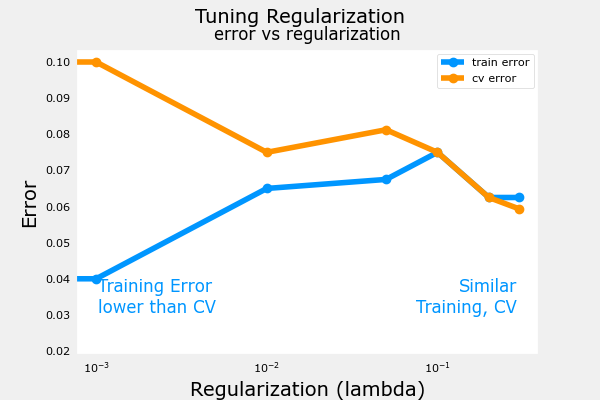

In [39]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)

As regularization is increased, the performance of the model on the training and cross-validation data sets converge. For this data set and model, lambda > 0.01 seems to be a reasonable choice.

<a name="7.1"></a>
### 7.1 Test
Let's try our optimized models on the test set and compare them to 'ideal' performance. 

3/3 [==============================] - 0s 1ms/step


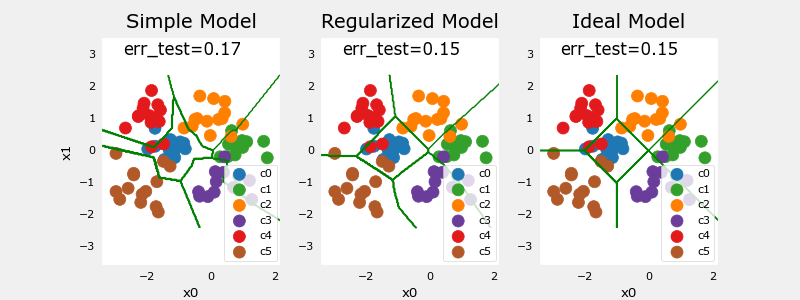

In [40]:
plt_compare(X_test,y_test, classes, model_predict_s, model_predict_r, centers)

Our test set is small and seems to have a number of outliers so classification error is high. However, the performance of our optimized models is comparable to ideal performance.

## Congratulations! 
You have become familiar with important tools to apply when evaluating your machine learning models. Namely:  
* splitting data into trained and untrained sets allows you to differentiate between underfitting and overfitting
* creating three data sets, Training, Cross-Validation and Test allows you to
    * train your parameters $W,B$ with the training set
    * tune model parameters such as complexity, regularization and number of examples with the cross-validation set
    * evaluate your 'real world' performance using the test set.
* comparing training vs cross-validation performance provides insight into a model's propensity towards overfitting (high variance) or underfitting (high bias)